Import Thư viện cần thiết


In [117]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.saving import load_model
from PIL import Image

Tải model đã train trên kaggle

In [118]:
loaded_model = load_model('model_epoch_03.keras')

Test model

In [119]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
input_size = (128,128)
val_frac = 0.1

test_data = "./Testing"
data_augmentor = ImageDataGenerator(samplewise_center=True,           
                                    samplewise_std_normalization=True, )
                                    
test_generator = data_augmentor.flow_from_directory(test_data, 
                                                  target_size=input_size,
                                                  batch_size=1,
                                                  shuffle=None,
                                                  class_mode=None)

Found 5712 images belonging to 4 classes.


In [120]:
classes = test_generator.class_indices
classes = dict((v,k) for k,v in classes.items())
classes

{0: 'Normal', 1: 'glioma_tumor', 2: 'meningioma_tumor', 3: 'pituitary_tumor'}

In [121]:
import matplotlib.pyplot as plt
import cv2
from glob import glob

In [122]:
test_images = glob('./Testing/Normal/*.jpg') 
test_images[:15]


['./Testing/Normal\\Tr-noTr_0000.jpg',
 './Testing/Normal\\Tr-noTr_0001.jpg',
 './Testing/Normal\\Tr-noTr_0002.jpg',
 './Testing/Normal\\Tr-noTr_0003.jpg',
 './Testing/Normal\\Tr-noTr_0004.jpg',
 './Testing/Normal\\Tr-noTr_0005.jpg',
 './Testing/Normal\\Tr-noTr_0006.jpg',
 './Testing/Normal\\Tr-noTr_0007.jpg',
 './Testing/Normal\\Tr-noTr_0008.jpg',
 './Testing/Normal\\Tr-noTr_0009.jpg',
 './Testing/Normal\\Tr-no_0010.jpg',
 './Testing/Normal\\Tr-no_0011.jpg',
 './Testing/Normal\\Tr-no_0012.jpg',
 './Testing/Normal\\Tr-no_0013.jpg',
 './Testing/Normal\\Tr-no_0014.jpg']

Text(0.5, 1.0, 'Normal\\Tr-no_0010.jpg')

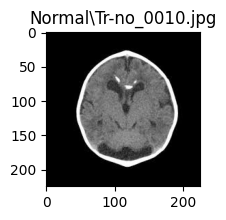

In [143]:
test_image_path = test_images[10]
im = cv2.imread(test_image_path)
plt.rcParams['figure.figsize'] = (2.0, 2.0)
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.title(test_image_path.split("/")[-1])

In [144]:
from tensorflow.keras.preprocessing import image

img = image.load_img(test_image_path, target_size=(input_size))  # Resize về (128, 128)
img_array = image.img_to_array(img)                              # Chuyển từ kiểu dữ liệu hình sang kiểu numpy array

img_array = np.expand_dims(img_array, axis=0)                    # Thêm chiều n=1, nghĩa là batch_size=1 => phù hợp cho việc dự đoán
test_datagen = ImageDataGenerator(                               # Bắt buộc áp dụng các phương pháp tiền xử lý như tập train
    samplewise_center=True,            
    samplewise_std_normalization=True
)
img_generator = test_datagen.flow(img_array, batch_size=1)       # Thay vì sử dụng `flow_from_directory` thì chỉ sử dụng `flow`

prediction = loaded_model.predict(next(img_generator))           # Sử dụng phương thức .predict()
prediction_label = np.argmax(prediction)
print("Prediction:", classes[prediction_label])



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Prediction: glioma_tumor


Linear Regression

In [125]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder



In [126]:
df = pd.read_csv('BrainTumor.csv')
df.isnull().sum()

Patient ID                       0
Age                              0
Gender                           0
Tumor Type                       0
Tumor Grade                      0
Tumor Location                   0
Treatment                        0
Treatment Outcome                0
Time to Recurrence (months)    562
Recurrence Site                562
Survival Time (months)           0
dtype: int64

In [127]:
df['Age'].unique()

array([45, 55, 60, 50, 65, 57, 48, 70, 42, 58, 52, 63, 47, 68, 53, 49, 61,
       56, 72, 46, 54, 59, 51, 64, 43, 67, 62, 69, 44, 66, 71])

In [128]:
df['Treatment'].value_counts()

Treatment
Surgery + Radiation            882
Surgery + Chemotherapy         779
Surgery                        139
Chemotherapy                   123
Radiation                       73
Surgery + Radiation therapy      2
Chemotherapy + Radiation         2
Name: count, dtype: int64

In [129]:
df['Tumor Type'] = df['Tumor Type'].replace({
    'Glioblastoma': 'Glioma',
    'Astrocytoma': 'Glioma'
})

In [130]:
df['Tumor Type'].unique()


array(['Glioma', 'Meningioma'], dtype=object)

In [131]:
df.drop(columns=['Patient ID','Tumor Grade','Tumor Location','Treatment Outcome','Time to Recurrence (months)','Recurrence Site','Survival Time (months)'], inplace=True)


In [132]:
# df = df[df['Treatment'] != 'Surgery + Radiation therapy']
# df = df[df['Treatment'] != 'Chemotherapy + Radiation']

In [133]:
df['Treatment'].value_counts()

Treatment
Surgery + Radiation            882
Surgery + Chemotherapy         779
Surgery                        139
Chemotherapy                   123
Radiation                       73
Surgery + Radiation therapy      2
Chemotherapy + Radiation         2
Name: count, dtype: int64

In [134]:
le_gender = LabelEncoder()
le_tumor = LabelEncoder()
le_treatment = LabelEncoder()
df['Gender'] = le_gender.fit_transform(df['Gender'])
df['Tumor Type'] = le_tumor.fit_transform(df['Tumor Type'])
df['Treatment'] = le_treatment.fit_transform(df['Treatment'])


In [135]:
x = df[['Age','Gender','Tumor Type']]
y = df['Treatment']

In [136]:
print(df['Treatment'].value_counts())

Treatment
5    882
4    779
3    139
0    123
2     73
6      2
1      2
Name: count, dtype: int64


In [137]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1,random_state=42)


model = RandomForestClassifier()
model.fit(x_train, y_train)

RandomForestClassifier()

In [138]:
from sklearn.metrics import accuracy_score


In [139]:
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.675

In [140]:
new_patient = [[12, le_gender.transform(['Female'])[0], le_tumor.transform(['Glioma'])[0]]]
treatment_pred = model.predict(new_patient)

# Giải mã kết quả
print("Gợi ý điều trị:", le_treatment.inverse_transform(treatment_pred)[0])

Gợi ý điều trị: Surgery + Chemotherapy


c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
